In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Dropout, Cropping2D
%matplotlib inline

Using TensorFlow backend.


### Read the csv file and plot the data
To understand what's in the data we first read in the dataset and visualize a few images and their steering angles

In [33]:
rmwhtspc = lambda x: x.strip()
def read_csv_data(root):
    driving_df = pd.read_csv(os.path.join(root, "driving_log.csv"))
    driving_df["center"] = root + "/" + driving_df["center"].astype("str").map(rmwhtspc)
    driving_df["left"] = root + "/" + driving_df["left"].astype("str").map(rmwhtspc)
    driving_df["right"] = root + "/" +  driving_df["right"].astype("str").map(rmwhtspc)
    return driving_df

df1 = read_csv_data("../data")
df1.head()
df1.describe()

,steering,throttle,brake,speed
count,8036.000000,8036.000000,8036.000000,8036.000000
mean,0.004070,0.869660,0.001970,28.169839
std,0.128840,0.301326,0.036565,6.149327
min,-0.942695,0.000000,0.000000,0.502490
25%,0.000000,0.985533,0.000000,30.183093
50%,0.000000,0.985533,0.000000,30.186400
75%,0.000000,0.985533,0.000000,30.186640
max,1.000000,0.985533,1.000000,30.709360


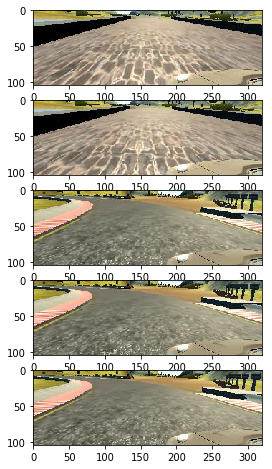

In [34]:
#Visualize some data
n = np.random.randint(0, df1.shape[0], 5)
w, h = 6, 8
fig = plt.figure(figsize = (w,h))



def flip_img(img, steering):
    out_img = np.fliplr(img)
    out_steer = - steering
    return out_img, out_steer

def process_image(img):
    img_out = img[55:,:]
    #print(img_out.shape)
    return img_out

for i, idx in enumerate(n):
    fig.add_subplot(5, 1, i+1)
    img = process_image(plt.imread( df1.iloc[i]["left"]))
    plt.imshow(img)

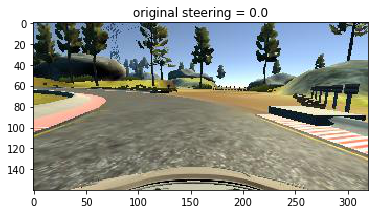

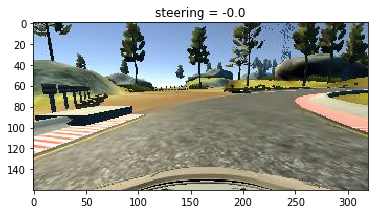

In [35]:
    
#Plot flipped image for debugging
im = plt.imread(df1.iloc[10]["center"])
steer = df1.iloc[3000]["steering"]

flipped_im, flipped_steer = flip_img(im, steer)
plt.figure()
plt.imshow(im)
plt.title("original steering = " + str(steer))

plt.figure()
plt.imshow(flipped_im)
plt.title("steering = " + str(flipped_steer))

float64
0.0


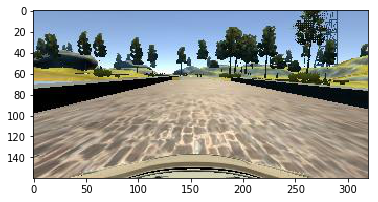

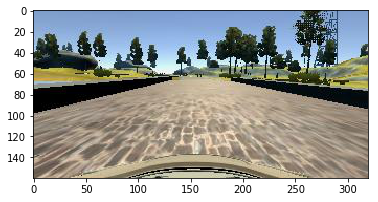

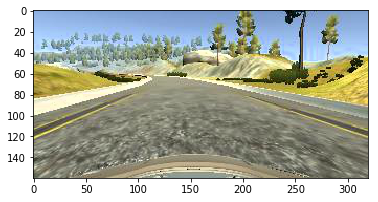

In [36]:
import sklearn.utils
from skimage import color

def image_brighten_darken(img, scale=0.25):
    hsv = color.rgb2hsv(img)
    v = hsv[:, :, 2] * (1 + np.random.uniform(-scale, scale))
    v[ v > 1] = 1
    v[ v < 0] = 0
    hsv[:, :, 2] = v
    rgb = color.hsv2rgb(hsv).astype(np.float32)
    return rgb

#debug
im = plt.imread( df1.iloc[0]["center"])
plt.figure()
plt.imshow(im)
plt.figure()
im2 = image_brighten_darken(im, scale = 0.3)
plt.imshow(im2)

#Keras generator: This generator will yeild 4x the batch size 
def genbatchdata(batch_size = 32, correction = 0.25):
    num_samples = df1.shape[0]
    while 1:
        idxes = np.random.permutation(num_samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = idxes[offset:offset+batch_size]

            images = np.zeros((batch_size, 160, 320, 3))
            targets = np.zeros((batch_size,))
            
            for i, batch_sample in enumerate(batch_samples):
                row = df1.iloc[batch_sample]
                center_name = row["center"]
                left_name = row["left"]
                right_name = row["right"]
                
                steering = row["steering"].astype(np.float32) 
                choice = 0
                if choice == 0:
                    img = image_brighten_darken(plt.imread(center_name))
                elif choice == 1:
                    img = image_brighten_darken(plt.imread(left_name))
                    steering = steering + correction
                elif choice == 2:
                    img = image_brighten_darken(plt.imread(right_name))
                    steering = steering - correction
                else:
                    img, steering = flip_img(img, steering)
              
                images[i] = img
                targets[i] = steering

            yield images, targets

def print_batch(debug):
    if debug:
        g = genbatchdata()
        x, y = next(g)
        plt.figure()
        plt.imshow(x[31])
        print(x[31].dtype)
        plt.imshow(x[23])
        print(y[31])

debug = True
print_batch(debug)

### Create the Neural Network model

In [37]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.utils import plot_model
from keras.layers import Input, GlobalAveragePooling2D, Lambda, Flatten, Conv2D, Cropping2D, BatchNormalization
from keras.models import Model, Sequential

In [42]:
#Using transfer learning from InceptionV3 model
def inceptiontlmodel():
    #input 
    input_tensor = Input(shape=(160, 320, 3))
    #normalize data
    #normalized_tensor = Lambda(lambda x: 2. * ( (x / 255.0) - 0.5 ))(input_tensor)
    #crop image
    cropped_tensor = Cropping2D(cropping=((55,20), (0,0)))(normalized_tensor)
    #base model with cropped image tensor as input
    base_model = InceptionV3(input_tensor=cropped_tensor, weights='imagenet', include_top=False)
    # add a global spatial average pooling layer
    x = base_model.output
    x = Flatten()(x)
    x = Dense(1000, activation="relu", name = "fc1")(x)
    x = Dense(1000, activation="relu", name = "fc1")(x)

    # let's add a fully-connected layer
    x = Dense(100, activation = "relu", name = "fc2")(x)
    # and a regression layer
    predictions = Dense(1, name = "steering")(x)
    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all convolutional InceptionV3 layers
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(optimizer = "adam", loss="mse")
    return model

def nvidiamodel():
    model = Sequential()
    model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape = (160, 320, 3) ) )
    #model.add(Lambda(lambda x:  (x / 255.0) - 0.5) )
    model.add(Conv2D(24, 5, strides =(2,2) , activation = "relu"))
    model.add(Conv2D(36, 5, strides = 2, activation = "relu"))
    model.add(BatchNormalization())
    model.add(Conv2D(48, 3, strides = 2, activation = "relu"))
    model.add(BatchNormalization())
    model.add(Conv2D(64, 3, strides = 2, activation = "relu"))
    model.add(BatchNormalization())
    model.add(Conv2D(64, 3, strides = 2, activation = "relu"))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(1164, activation = "relu"))
    model.add(Dense(100, activation = "relu"))
    model.add(Dense(50, activation = "relu"))
    model.add(Dense(10, activation="relu"))
    model.add(Dense(1, name = "predictions"))
    model.compile(optimizer = "adam", loss = "mse")
    return model

def simplemodel():
    model = Sequential()
    model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape = (160, 320, 3) )) 
    model.add(Conv2D(32, 5, strides = 2, activation="relu"))
    model.add(BatchNormalization())
    model.add(Conv2D(64, 5, strides = 2, activation="relu"))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(512, activation  = "relu"))
    model.add(Dense(100, activation = "relu"))
    model.add(Dense(1))
    model.compile(optimizer = "adam", loss = "mse")
    return model
    

In [46]:
model = simplemodel()
model.summary()

import keras.backend as K
from keras.callbacks import TensorBoard
import os
import tensorflow as tf

if not os.path.exists("models"):
    os.mkdir("models")

sess = K.get_session()
train_writer = tf.summary.FileWriter("models", sess.graph)
train_writer.add_graph(sess.graph)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_8 (Cropping2D)    (None, 90, 320, 3)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 43, 158, 32)       2432      
_________________________________________________________________
batch_normalization_13 (Batc (None, 43, 158, 32)       128       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 20, 77, 64)        51264     
_________________________________________________________________
batch_normalization_14 (Batc (None, 20, 77, 64)        256       
_________________________________________________________________
flatten_7 (Flatten)          (None, 98560)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 512)               50463232  
__________

In [47]:
batch_size = 32
num_batches = df1.shape[0] // batch_size
logger = TensorBoard(log_dir='./logs', batch_size= batch_size)
model.fit_generator(genbatchdata(batch_size, correction = 0.2), num_batches, epochs = 2, callbacks = [logger])

Epoch 1/2
183/251 [====================>.........] - ETA: 227s - loss: 39.1682   

KeyboardInterrupt: 

In [48]:
model.save('simplemodel.h5')